In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as sio
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    pass

%run ./split_step_fourier.ipynb

# showing figures inline
%matplotlib inline
# plotting options 
font = {'size': 12}
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [2]:
# parameters of the filters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10 # samples per symbol (>1 => oversampling)
r_rc = .33
r_rrc = .33
syms_per_filt = 4  # symbols per filter (plus minus in both directions)

# calculation of firs
t_sample_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)
t_sample_rrc, rrc = get_rrc_ir(syms_per_filt, r_rrc, f_symbol, n_up)
t_sample_gaussian, gaussian = get_gaussian_ir(syms_per_filt, f_symbol, n_up)

# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}
n_symbol = 4 # number of symbols

# generate send signal
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)

send_rc = generate_signal(modulation, send_bits, rc, syms_per_filt)
send_rrc = generate_signal(modulation, send_bits, rrc, syms_per_filt)
send_gaussian = generate_signal(modulation, send_bits, gaussian, 0)

In [3]:
# Transmission
z_length = 30  # [km]
nz = 100  # steps
dz = z_length / nz  # [km]

alpha = 0.  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

output, linop, nonlinop = splitstepfourier(send_rc, t_sample_rc, dz, nz, alpha, beta2, gamma)

# export to mat file
sio.savemat('../matlab/vars.mat', {'u0': send_rc, 'dt': t_sample_rc, 'dz': dz, 'nz': nz, 'alpha': alpha, 'betap': [0, 0, beta2], 'gamma': gamma})

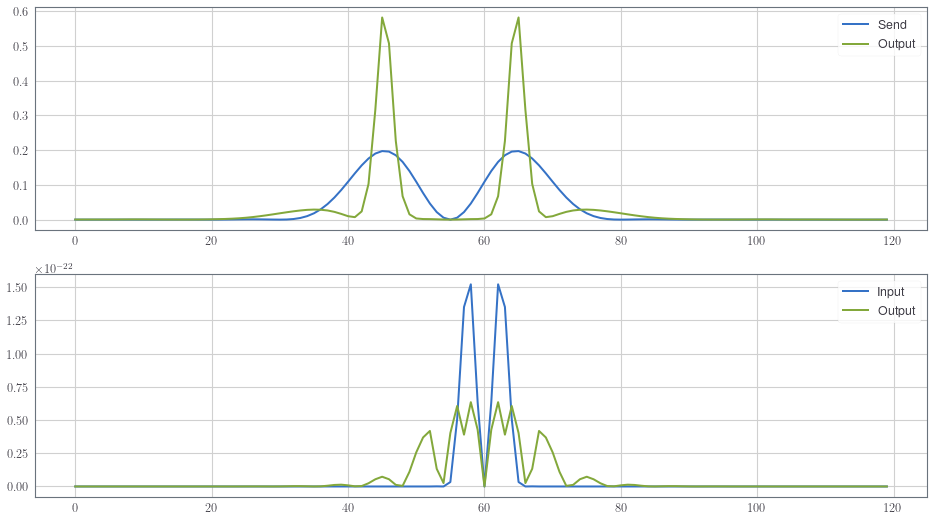

In [4]:
# Plotting
fig = plt.figure(figsize=(16, 9))
sbplt1 = fig.add_subplot(211)
sbplt1.plot(np.square(abs(send_rc)), linewidth=2.0, label='Send')
sbplt1.plot(np.square(abs(output)), linewidth=2.0, label='Output')

sbplt1.grid(True)
sbplt1.legend(loc='upper right')

sbplt2 = fig.add_subplot(212)
sbplt2.plot(np.fft.fftshift(np.square(abs(t_sample_rc*np.fft.fft(send_rc)/np.sqrt(2*np.pi)))), linewidth=2.0, label='Input')
sbplt2.plot(np.fft.fftshift(np.square(abs(t_sample_rc*np.fft.fft(output)/np.sqrt(2*np.pi)))), linewidth=2.0, label='Output')

sbplt2.grid(True)
sbplt2.legend(loc='upper right')
fig.savefig("demo_python.png")